
# Modelling Phase


> [K-Means / GMM / DBSCAN / Hierarchical / PCA+KMeans]


## Instruksi:

1. Notebook only for modelling
2. JANGAN ngerubah bagian "Standarization", "Modelling diluar bagian kalian" & "Evaluation Function" biar hasilnya konsisten.
3. Workspace di bagian "Modelling".
4. Simpen hasil label cluster ke dalam kolom baru.

## #1. Setup & Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn defaults
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## #2. Data Loading

In [ ]:
DATA_PATH = 'dhs_regional_panel.csv'

df = pd.read_csv(DATA_PATH)

# Preview data
print(f"Shape Data: {df.shape}")
df.head()

Shape Data: (96, 13)


,year,v024,province_name,anc4_pct,facility_delivery_pct,sba_pct,urban_share_pct,low_education_pct,risky_maternal_age_pct,birth_interval_short_pct,avg_parity,lbw_pct,full_immun_pct
0,2002,12,Sumatera Utara,0.709615,0.344487,0.827922,0.429960,0.386486,0.278940,0.391190,3.019732,0.115147,0.348179
1,2002,13,Sumatera Barat,0.865139,0.602981,0.820163,0.394327,0.337632,0.299571,0.300608,2.816498,0.149896,0.539392
2,2002,14,Riau,0.837971,0.381888,0.758697,0.534813,0.394638,0.366670,0.247384,2.578850,0.130668,0.496350
3,2002,15,Jambi,0.799175,0.379680,0.718145,0.310392,0.502543,0.451023,0.171904,2.399863,0.081931,0.395001
4,2002,16,Sumatera Selatan,0.793440,0.371098,0.773976,0.313627,0.545571,0.449110,0.224071,2.602079,0.096247,0.467269


## #3. Standardization

In [ ]:
df.drop(columns=['avg_parity'], inplace=True)

feature_cols = [
    'anc4_pct',
    'facility_delivery_pct',
    'sba_pct',
    'urban_share_pct',
    'low_education_pct',
    'risky_maternal_age_pct',
    'birth_interval_short_pct',
    'lbw_pct',
    'full_immun_pct'
]

In [ ]:
# Scaling menggunakan StandardScaler (Z-Score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])

df_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

print("Statistik Data Scaled (Mean harus ~0, Std harus ~1):")
df_scaled.describe().loc[['mean', 'std']].round(2)

Statistik Data Scaled (Mean harus ~0, Std harus ~1):


,anc4_pct,facility_delivery_pct,sba_pct,urban_share_pct,low_education_pct,risky_maternal_age_pct,birth_interval_short_pct,lbw_pct,full_immun_pct
mean,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00
std,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01


## #4. Modelling
* Pastikan output akhirnya adalah array/list bernama `labels`.

In [ ]:
# Functional Helper

def evaluate_clustering(X, labels):
    """
    Menghitung 3 metrik utama: Silhouette, DBI, CH Score.
    X: Data yang sudah di-scale (df_scaled)
    labels: Label hasil cluster
    """
    # Cek jika cluster hanya 1 (error handling untuk DBSCAN jika semua noise)
    unique_labels = set(labels)
    if len(unique_labels) < 2:
        print("Gagal hitung metrik: Hanya terbentuk 1 cluster.")
        return None

    # Untuk DBSCAN, mengabaikan noise (-1) dalam perhitungan Silhouette
    if -1 in labels:
        X_core = X[labels != -1]
        labels_core = labels[labels != -1]
    else:
        X_core = X
        labels_core = labels

    sil = silhouette_score(X_core, labels_core)
    dbi = davies_bouldin_score(X_core, labels_core)
    ch = calinski_harabasz_score(X_core, labels_core)

    print(f"Silhouette Score (Higher is better) : {sil:.4f}")
    print(f"Davies-Bouldin   (Lower is better)  : {dbi:.4f}")
    print(f"Calinski-Harabasz (Higher is better): {ch:.4f}")

    return {'Silhouette': sil, 'DBI': dbi, 'CH': ch}

### 4.1 K-Means (Baseline)

Sedang mencari K optimal...


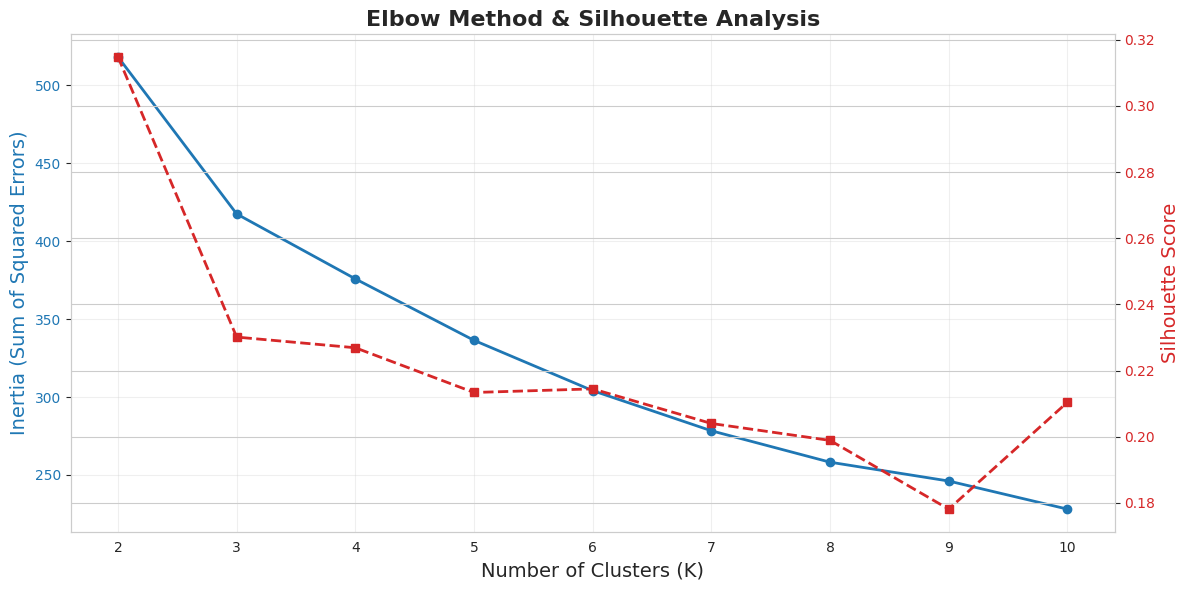

K     Inertia         Silhouette     
----------------------------------------
2     518.31          0.3148         
3     417.52          0.2301         
4     375.84          0.2269         
5     336.38          0.2134         
6     304.08          0.2144         
7     278.33          0.2040         
8     258.17          0.1989         
9     246.07          0.1781         
10    228.04          0.2104         


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Range K yang mau dicoba (misal 2 sampai 10)
range_n_clusters = range(2, 11)

inertia = []
silhouette_avg = []

print("Sedang mencari K optimal...")

for k in range_n_clusters:
    # Run K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)

    # Simpan Inertia (Sum of Squared Distances)
    inertia.append(kmeans.inertia_)

    # Simpan Silhouette Score
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

# --- PLOTTING ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 1: Elbow Method (Inertia) - Garis Biru
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (K)', fontsize=14)
ax1.set_ylabel('Inertia (Sum of Squared Errors)', color=color, fontsize=14)
ax1.plot(range_n_clusters, inertia, marker='o', linestyle='-', color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Bikin sumbu Y kedua (kanan) untuk Silhouette
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color, fontsize=14)
ax2.plot(range_n_clusters, silhouette_avg, marker='s', linestyle='--', color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method & Silhouette Analysis', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()

print(f"{'K':<5} {'Inertia':<15} {'Silhouette':<15}")
print("-" * 40)
for k, inert, sil in zip(range_n_clusters, inertia, silhouette_avg):
    print(f"{k:<5} {inert:<15.2f} {sil:<15.4f}")

In [ ]:
model = KMeans(n_clusters=3, random_state=42)
labels = model.fit_predict(df_scaled)

df['Cluster'] = labels

print("\nSebaran Anggota Cluster:")
print(df['Cluster'].value_counts())


Sebaran Anggota Cluster:
Cluster
1    38
2    35
0    23
Name: count, dtype: int64


In [ ]:
print(f"--- K - Means Evaluation Metrics ---")
metrics = evaluate_clustering(df_scaled.values, labels) # K_Means Baseline

--- K - Means Evaluation Metrics ---
Silhouette Score (Higher is better) : 0.2301
Davies-Bouldin   (Lower is better)  : 1.3647
Calinski-Harabasz (Higher is better): 49.7254


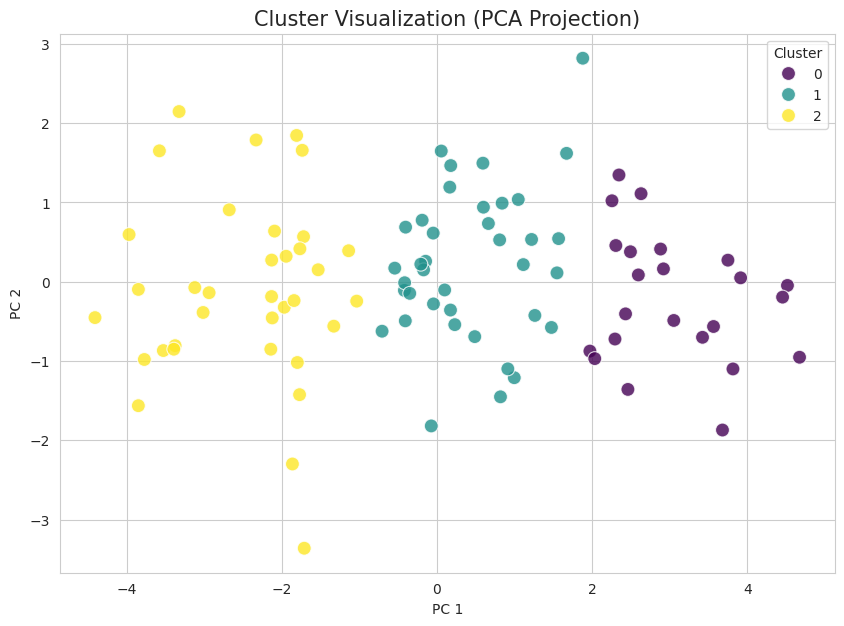

In [ ]:
pca_viz = PCA(n_components=2)
X_pca = pca_viz.fit_transform(df_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df['Cluster'],
    palette='viridis',
    s=100,
    alpha=0.8
)
plt.title(f'Cluster Visualization (PCA Projection)', fontsize=15)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Cluster')
plt.show()

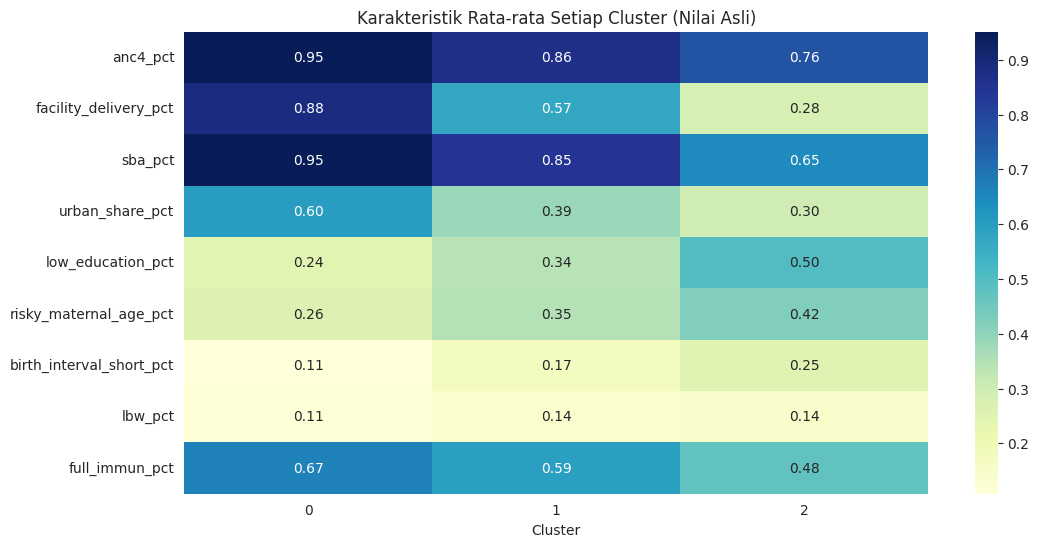

,anc4_pct,facility_delivery_pct,sba_pct,urban_share_pct,low_education_pct,risky_maternal_age_pct,birth_interval_short_pct,lbw_pct,full_immun_pct
Cluster,,,,,,,,,
0,0.950164,0.880241,0.951128,0.603450,0.243186,0.256257,0.108026,0.114909,0.666667
1,0.863345,0.570035,0.845533,0.387894,0.344001,0.348004,0.170710,0.139915,0.592540
2,0.764353,0.277335,0.648961,0.300235,0.502794,0.423757,0.247544,0.144866,0.476094


In [ ]:
# Group by Cluster dan hitung rata-rata tiap fitur
numeric_cols = feature_cols + ['Cluster']
cluster_profile = df[numeric_cols].groupby('Cluster').mean()

# Tampilkan Heatmap Profiling
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profile.T, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title('Karakteristik Rata-rata Setiap Cluster (Nilai Asli)')
plt.show()

# View Table
cluster_profile

### 4.2 PCA + K-Means

In [ ]:
# ANALISIS VARIANS
pca_full = PCA()
pca_full.fit(df_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("=== ANALISIS VARIANS PCA ===")
print(f"{'PC':<5} {'Explained Var':<15} {'Cumulative Var':<15}")
print("-" * 40)
for i, (var, cum) in enumerate(zip(explained_variance, cumulative_variance), 1):
    print(f"PC{i:<2} {var:.4f} ({var*100:.1f}%)   {cum:.4f} ({cum*100:.1f}%)")


=== ANALISIS VARIANS PCA ===
PC    Explained Var   Cumulative Var 
----------------------------------------
PC1  0.5794 (57.9%)   0.5794 (57.9%)
PC2  0.1126 (11.3%)   0.6920 (69.2%)
PC3  0.1025 (10.3%)   0.7945 (79.5%)
PC4  0.0706 (7.1%)   0.8651 (86.5%)
PC5  0.0513 (5.1%)   0.9164 (91.6%)
PC6  0.0373 (3.7%)   0.9537 (95.4%)
PC7  0.0205 (2.1%)   0.9742 (97.4%)
PC8  0.0153 (1.5%)   0.9895 (99.0%)
PC9  0.0105 (1.0%)   1.0000 (100.0%)


In [ ]:
from sklearn.cluster import KMeans

# MODELING (Fixed n_components=4)
n_components_final = 4

print(f"\nUsing {n_components_final} as main component for clustering.")

pca_final = PCA(n_components=n_components_final, random_state=42)
X_pca = pca_final.fit_transform(df_scaled)

# Jalankan K-Means pada data hasil reduksi
kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca)

# Simpan ke DataFrame utama
df['Cluster_PCA'] = labels_pca
print(f"Distribusi Cluster:\n{df['Cluster_PCA'].value_counts()}")


Using 4 as main component for clustering.
Distribusi Cluster:
Cluster_PCA
2    38
1    35
0    23
Name: count, dtype: int64


In [ ]:
print(f"--- K - Means + PCA Evaluation Metrics ---")
metrics_pca = evaluate_clustering(X_pca, labels_pca)  # K_Means + PCA

--- K - Means + PCA Evaluation Metrics ---
Silhouette Score (Higher is better) : 0.2934
Davies-Bouldin   (Lower is better)  : 1.1493
Calinski-Harabasz (Higher is better): 67.9912


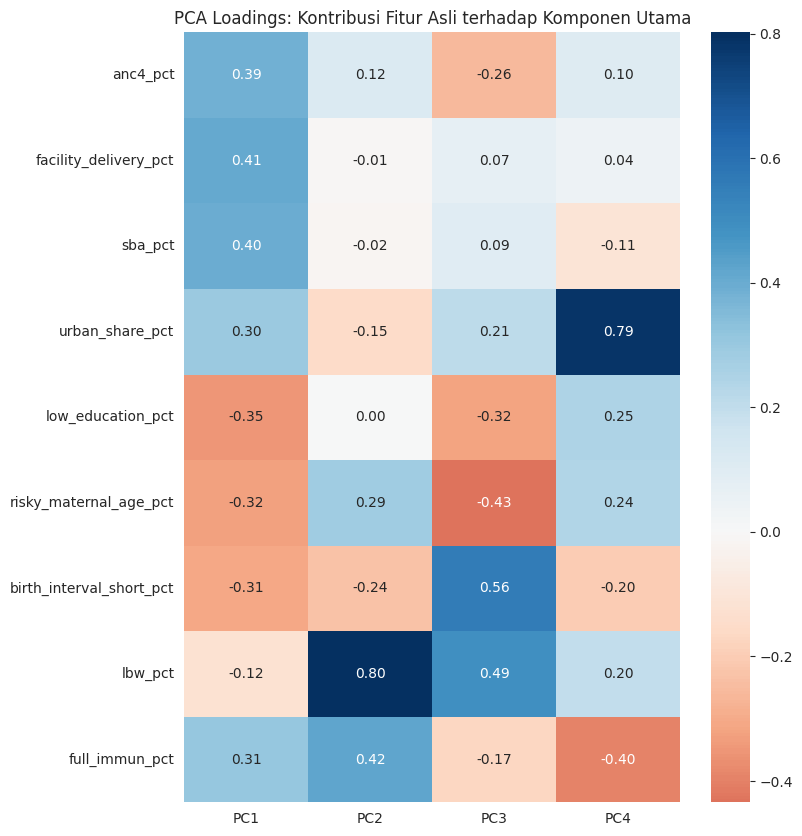


Matriks Loadings (Angka Mutlak Terbesar = Fitur Paling Berpengaruh):
                               PC1       PC2       PC3       PC4
anc4_pct                  0.385352  0.119939 -0.255711  0.102751
facility_delivery_pct     0.408683 -0.007861  0.074435  0.039345
sba_pct                   0.400181 -0.015611  0.093719 -0.106798
urban_share_pct           0.298976 -0.151289  0.212870  0.787147
low_education_pct        -0.353194  0.001760 -0.318836  0.246819
risky_maternal_age_pct   -0.324674  0.288068 -0.434181  0.240814
birth_interval_short_pct -0.309365 -0.235669  0.560484 -0.203981
lbw_pct                  -0.124818  0.802233  0.491881  0.195065
full_immun_pct            0.305787  0.424636 -0.169457 -0.397894


In [ ]:
# INTERPRETASI PCA LOADINGS
# matriks loading (baris=PC, kolom=Fitur Asli)
loadings = pd.DataFrame(
    pca_final.components_.T,  # Transpose biar Fitur jadi Baris
    columns=[f'PC{i+1}' for i in range(n_components_final)],
    index=feature_cols
)

plt.figure(figsize=(8, 10))
sns.heatmap(loadings, annot=True, cmap='RdBu', center=0, fmt='.2f')
plt.title('PCA Loadings: Kontribusi Fitur Asli terhadap Komponen Utama')
plt.show()

# Tampilkan Loadings Angka
print("\nMatriks Loadings (Angka Mutlak Terbesar = Fitur Paling Berpengaruh):")
print(loadings)

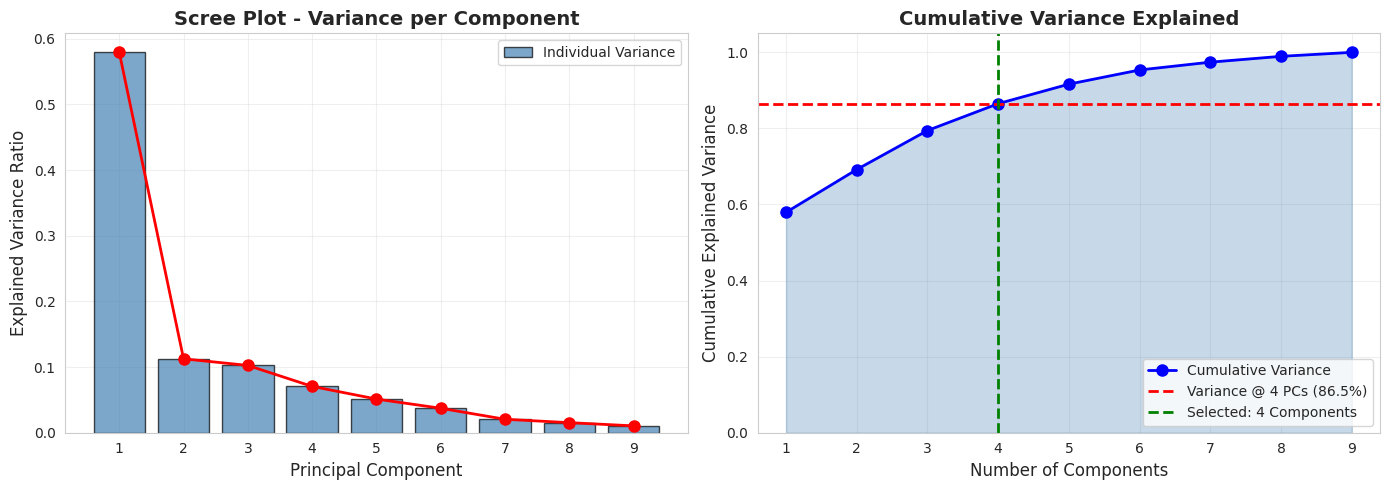

In [ ]:
# Visualization

# Tentukan target manual sesuai keputusan kita
n_components_final = 4
# Ambil variance kumulatif di titik ke-4 (indeks 3 karena mulai dari 0)
variance_at_4 = cumulative_variance[n_components_final-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Variance per Component (Scree Plot)
axes[0].bar(range(1, len(explained_variance) + 1), explained_variance,
            alpha=0.7, color='steelblue', edgecolor='black', label='Individual Variance')
axes[0].plot(range(1, len(explained_variance) + 1), explained_variance,
             'ro-', linewidth=2, markersize=8)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot - Variance per Component', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, len(explained_variance) + 1))
axes[0].legend()

# Plot 2: Cumulative Variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
             'bo-', linewidth=2, markersize=8, label='Cumulative Variance')

axes[1].axhline(y=variance_at_4, color='red', linestyle='--', linewidth=2,
                label=f'Variance @ {n_components_final} PCs ({variance_at_4*100:.1f}%)')

axes[1].axvline(x=n_components_final, color='green', linestyle='--', linewidth=2,
                label=f'Selected: {n_components_final} Components')

axes[1].fill_between(range(1, len(cumulative_variance) + 1), cumulative_variance,
                     alpha=0.3, color='steelblue')

axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10, loc='lower right')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(1, len(cumulative_variance) + 1))
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

### 4.3 Hierarchical Clustering

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

Dendrogram telah berhasil dibuat: dendrogram_hierarchical.png


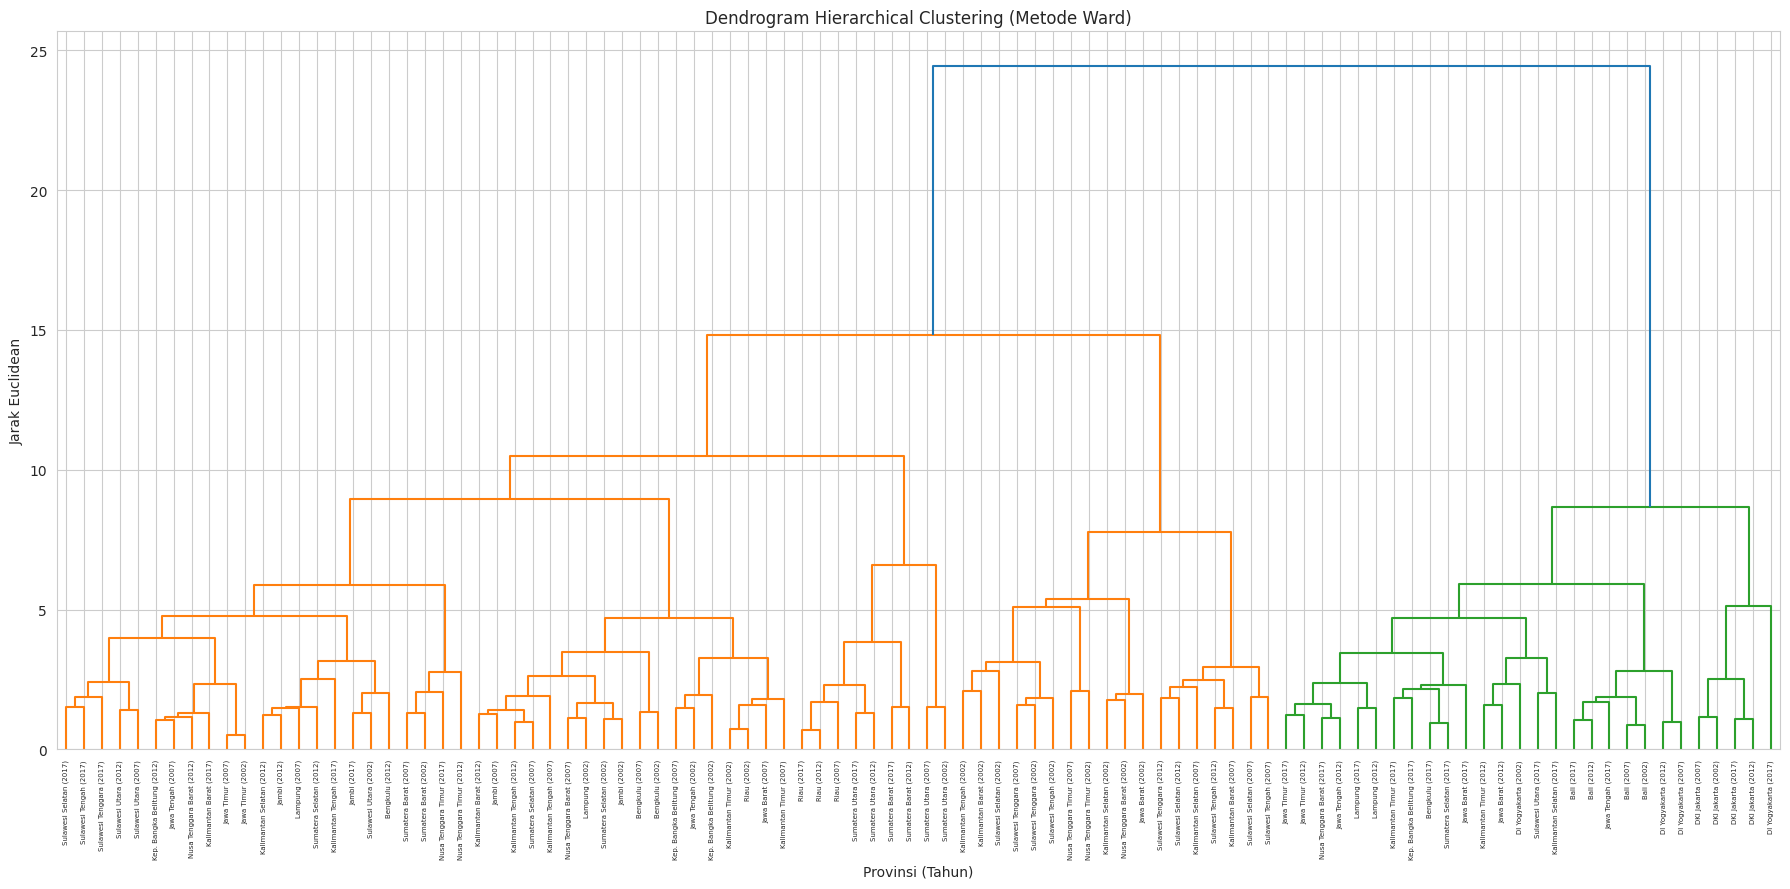

In [ ]:
    # Hitung Jarak (Linkage)
linked = linkage(df_scaled, method='ward', metric='euclidean')

# Plot Dendrogram
plt.figure(figsize=(18, 9))
dendrogram(linked,
           orientation='top',
           # Label gabung dari province_name dan year
           labels=np.array(df['province_name'].astype(str) + " (" + df['year'].astype(str) + ")"),
           distance_sort='descending',
           show_leaf_counts=True,
           truncate_mode='none')
plt.title('Dendrogram Hierarchical Clustering (Metode Ward)')
plt.xlabel('Provinsi (Tahun)')
plt.ylabel('Jarak Euclidean')
plt.tight_layout()
plt.savefig('dendrogram_hierarchical.png')

In [ ]:
# K=3 cluster dipilih dari Dendrogram
K_optimal = 3

# Model Agglomerative Clustering
hierarchical_model = AgglomerativeClustering(n_clusters=K_optimal, metric='euclidean', linkage='ward')
# cluster_labels adalah array hasil prediksi cluster (0, 1, 2, ..., K-1)
labels_hc = hierarchical_model.fit_predict(df_scaled)
df['Cluster_HC'] = labels_hc

print("\nSebaran Anggota Cluster:")
print(df['Cluster_HC'].value_counts())


Sebaran Anggota Cluster:
Cluster_HC
0    50
1    28
2    18
Name: count, dtype: int64


In [ ]:
print(f"--- Hierarchical Evaluation Metrics ---")
metrics_hc = evaluate_clustering(df_scaled.values, labels_hc)  # Hierarchical


--- Hierarchical Evaluation Metrics ---
Silhouette Score (Higher is better) : 0.2119
Davies-Bouldin   (Lower is better)  : 1.4123
Calinski-Harabasz (Higher is better): 41.7226


In [ ]:
# Profiling Rata-rata Cluster Hierarchical
numeric_cols = feature_cols + ['Cluster_HC']
profile_hc = df[numeric_cols].groupby('Cluster_HC').mean().T.round(2)

print("Profil Cluster Hierarchical:")
print(profile_hc)

Profil Cluster Hierarchical:
Cluster_HC                   0     1     2
anc4_pct                  0.84  0.94  0.74
facility_delivery_pct     0.48  0.83  0.23
sba_pct                   0.80  0.93  0.59
urban_share_pct           0.36  0.58  0.28
low_education_pct         0.40  0.26  0.51
risky_maternal_age_pct    0.36  0.28  0.44
birth_interval_short_pct  0.19  0.11  0.27
lbw_pct                   0.13  0.12  0.17
full_immun_pct            0.55  0.68  0.46


### 4.4 GMM

Mencari jumlah klaster optimal (K) menggunakan BIC...


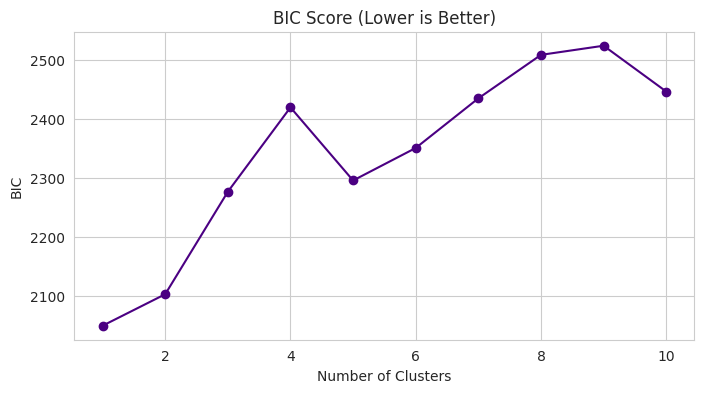

In [ ]:
from sklearn.mixture import GaussianMixture

# --- 1. BIC SCORE (Mencari K Optimal) ---
n_components = np.arange(1, 11)
bic_scores = []

print("Mencari jumlah klaster optimal (K) menggunakan BIC...")
for n in n_components:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))

# Plot BIC
plt.figure(figsize=(8, 4))
plt.plot(n_components, bic_scores, marker='o', color='indigo')
plt.title('BIC Score (Lower is Better)')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.grid(True)
plt.show()

In [ ]:
# TRAINING MODEL
n_components = 3

# Fit Model
# covariance_type='full' membiarkan cluster berbentuk lonjong (elips)
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(df_scaled)

# Predict Labels
labels_gmm = gmm.predict(df_scaled)
df['cluster_gmm'] = labels_gmm

# Hitung Sebaran Data
print("\nSebaran Anggota Cluster:")
print(df['cluster_gmm'].value_counts())


Sebaran Anggota Cluster:
cluster_gmm
1    36
2    34
0    26
Name: count, dtype: int64


In [ ]:
# ANALISIS PROBABILITAS
# Mengambil probabilitas setiap data masuk ke Cluster 0, 1, atau 2
probs = gmm.predict_proba(X_scaled)

# Ambil probabilitas tertinggi
confidence = probs.max(axis=1)
df['gmm_confidence'] = confidence

# Low Confidence Samples
# Ambang batas < 0.70 artinya model agak bingung
low_conf_threshold = 0.70
low_conf_samples = df[df['gmm_confidence'] < low_conf_threshold]

print("\n=== LOW CONFIDENCE SAMPLES (PROVINSI TRANSISI) ===")
print(f"Jumlah provinsi dengan confidence < {low_conf_threshold}: {len(low_conf_samples)}")
if len(low_conf_samples) > 0:
    # Tampilkan kolom penting saja
    print(low_conf_samples[['year', 'province_name', 'cluster_gmm', 'gmm_confidence']].sort_values('gmm_confidence'))
else:
    print("Model sangat yakin pada semua data (High Confidence).")


=== LOW CONFIDENCE SAMPLES (PROVINSI TRANSISI) ===
Jumlah provinsi dengan confidence < 0.7: 2
    year         province_name  cluster_gmm  gmm_confidence
31  2007  Kep. Bangka Belitung            2        0.602159
6   2002               Lampung            2        0.686620


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


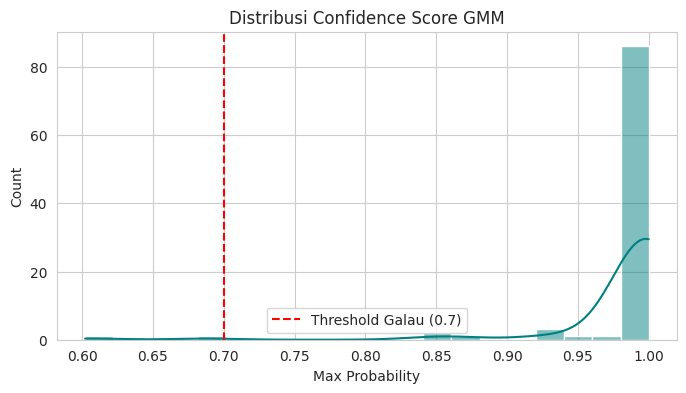

In [ ]:
#  Distribusi Keyakinan Model
plt.figure(figsize=(8, 4))
sns.histplot(df['gmm_confidence'], bins=20, kde=True, color='teal')
plt.title('Distribusi Confidence Score GMM')
plt.xlabel('Max Probability')
plt.axvline(x=0.7, color='red', linestyle='--', label='Threshold Galau (0.7)')
plt.legend()
plt.show()

In [ ]:
print(f"--- GMM Evaluation Metrics ---")
metrics_gmm = evaluate_clustering(X_scaled, labels_gmm)

--- GMM Evaluation Metrics ---
Silhouette Score (Higher is better) : 0.2061
Davies-Bouldin   (Lower is better)  : 1.4594
Calinski-Harabasz (Higher is better): 46.2965


### 4.5 DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

best_eps = 2.00
best_min_samples = 4

print(f"Running DBSCAN Final dengan eps={best_eps}, min_samples={best_min_samples}...")

# Fit Model
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_db = dbscan.fit_predict(df_scaled)
df['Cluster_DBSCAN'] = labels_db

# Sebaran Cluster
print("\nSebaran Cluster (Label -1 adalah Noise/Outlier):")
print(df['Cluster_DBSCAN'].value_counts())


Running DBSCAN Final dengan eps=2.0, min_samples=4...

Sebaran Cluster (Label -1 adalah Noise/Outlier):
Cluster_DBSCAN
 0    84
-1     8
 1     4
Name: count, dtype: int64


In [ ]:
# Evaluation
print(f"--- GMM Evaluation Metrics ---")
metrics_gmm = evaluate_clustering(df_scaled.values, labels_gmm)  # GMM

--- GMM Evaluation Metrics ---
Silhouette Score (Higher is better) : 0.2061
Davies-Bouldin   (Lower is better)  : 1.4594
Calinski-Harabasz (Higher is better): 46.2965


In [ ]:
# Noise Points
print("\n=== DAFTAR PROVINSI OUTLIER (NOISE) ===")
outliers = df[df['Cluster_DBSCAN'] == -1]
print(outliers[['year', 'v024', 'facility_delivery_pct', 'sba_pct', 'lbw_pct']].sort_values(by='year'))

# rata-rata karakteristik Outlier vs Normal
print("\nPerbandingan Rata-rata Outlier vs Cluster Utama:")
print(df.groupby('Cluster_DBSCAN')[feature_cols].mean().T.round(2))


=== DAFTAR PROVINSI OUTLIER (NOISE) ===
    year  v024  facility_delivery_pct   sba_pct   lbw_pct
0   2002    12               0.344487  0.827922  0.115147
15  2002    53               0.147989  0.375234  0.089173
17  2002    62               0.035076  0.540433  0.116556
22  2002    73               0.367732  0.649581  0.170650
24  2007    12               0.355034  0.863102  0.083805
39  2007    53               0.227765  0.491285  0.135706
63  2012    53               0.452428  0.597990  0.178413
83  2017    34               0.990636  0.984732  0.113787

Perbandingan Rata-rata Outlier vs Cluster Utama:
Cluster_DBSCAN              -1     0     1
anc4_pct                  0.75  0.85  0.97
facility_delivery_pct     0.37  0.54  0.93
sba_pct                   0.67  0.80  0.97
urban_share_pct           0.34  0.39  1.00
low_education_pct         0.45  0.38  0.20
risky_maternal_age_pct    0.29  0.37  0.22
birth_interval_short_pct  0.30  0.18  0.13
lbw_pct                   0.13  0.14  0.14


In [ ]:
print(f"--- DBSCAN Evaluation Metrics ---")
metrics_db = evaluate_clustering(df_scaled.values, labels_db)

--- DBSCAN Evaluation Metrics ---
Silhouette Score (Higher is better) : 0.2902
Davies-Bouldin   (Lower is better)  : 0.7578
Calinski-Harabasz (Higher is better): 11.5197


## #5. Deeper ANalysis

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi

# 1. Siapkan Data Rata-rata (Centroid) dari Data Asli
# Pastikan df punya kolom 'Cluster_PCA' dan fitur asli (belum di-scale)
means = df.groupby('Cluster_PCA')[feature_cols].mean()

# 2. Lakukan Min-Max Scaling KHUSUS untuk Visualisasi ini
# Tujuannya agar nilai terendah jadi 0 (pusat) dan tertinggi jadi 1 (pinggir)
# Ini membuat perbedaan antar cluster terlihat kontras
scaler = MinMaxScaler()
means_norm = pd.DataFrame(scaler.fit_transform(means), columns=feature_cols, index=means.index)

# --- MULAI PLOTTING ---
def create_radar_chart(means_norm, feature_cols):
    # Setup Sudut
    categories = feature_cols
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # Menutup lingkaran

    # Setup Plot
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)

    # Atur Posisi Label (Jam 12 sebagai awal)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Gambar Sumbu
    plt.xticks(angles[:-1], categories, size=10)

    # Atur Grid Y (Lingkaran dalam) - Biar tidak terlalu ramai
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1.0], ["25%", "50%", "75%", "Max"], color="grey", size=8)
    plt.ylim(0, 1.1) # Batas sedikit di atas 1 biar rapi

    # --- GAMBAR CLUSTER ---
    # Warna: Cluster 0 (Ungu/Maju), Cluster 1 (Teal/Transisi), Cluster 2 (Kuning/Tertinggal)
    colors = ['#440154', '#21908d', '#fde725'] # Palet Viridis
    labels = ['Cluster 0 (Maju)', 'Cluster 1 (Transisi)', 'Cluster 2 (Tertinggal)']

    for i, (idx, row) in enumerate(means_norm.iterrows()):
        values = row.tolist()
        values += values[:1] # Menutup loop

        ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
        ax.fill(angles, values, color=colors[i], alpha=0.1) # Arsir transparan

    # Finishing
    plt.title('Profil Karakteristik Klaster (Relative Comparison)', size=16, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()


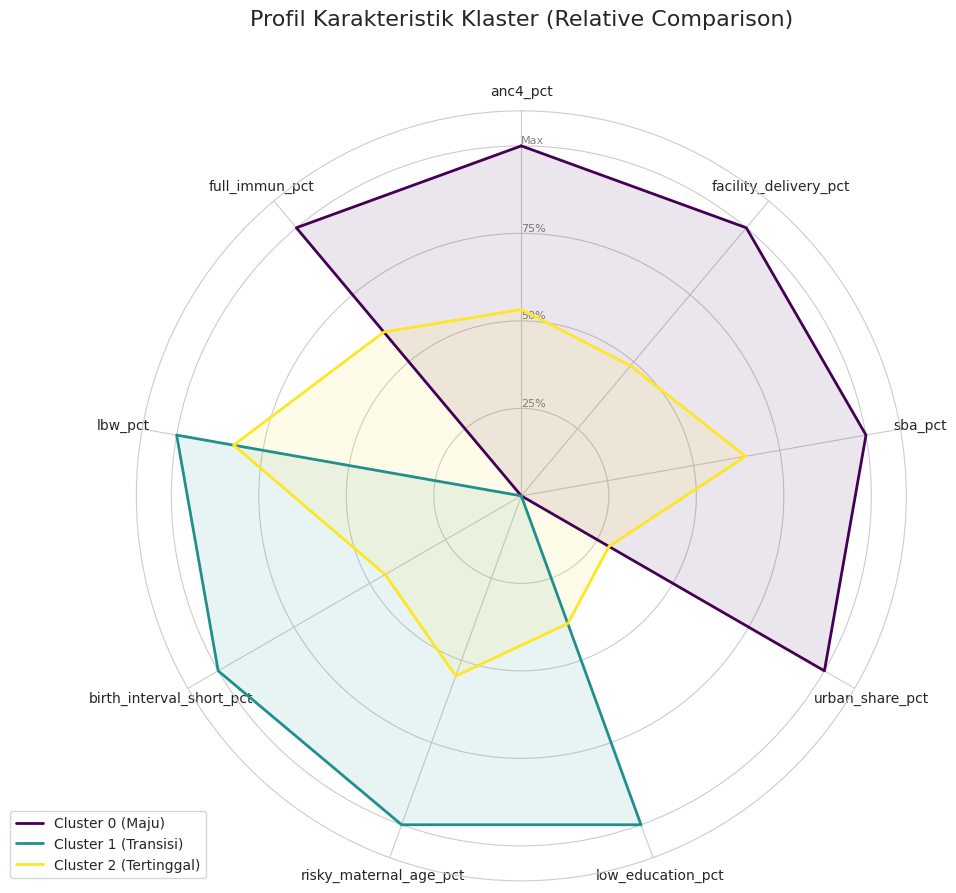

In [ ]:
# Panggil Fungsi
create_radar_chart(means_norm, feature_cols)

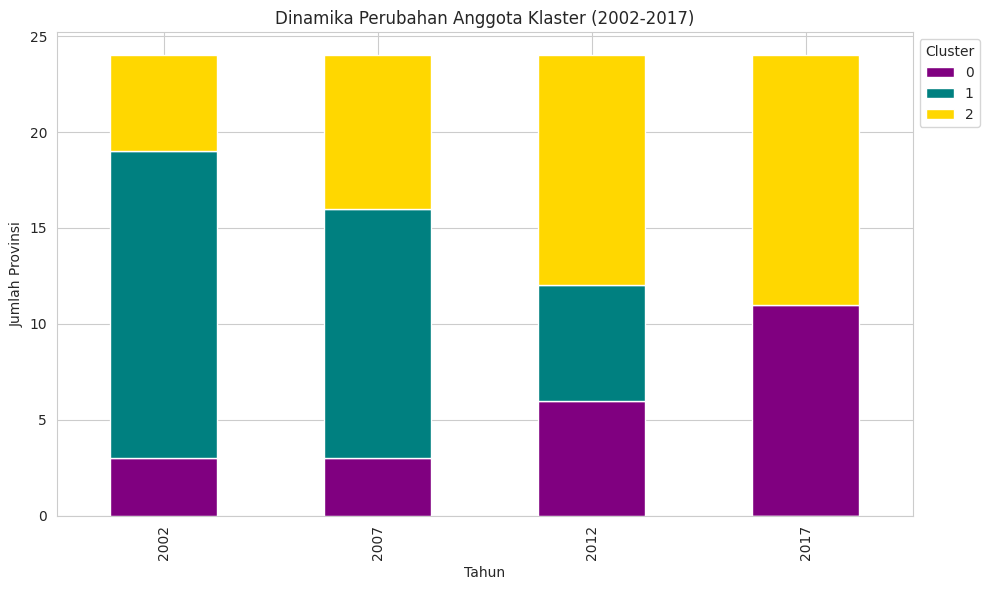

Jumlah Provinsi per Cluster per Tahun:
Cluster_PCA   0   1   2
year                   
2002          3  16   5
2007          3  13   8
2012          6   6  12
2017         11   0  13


In [ ]:
# --- ANALISIS TREN WAKTU (STACKED BAR) ---
# Hitung jumlah provinsi per cluster per tahun
trend_data = df.groupby(['year', 'Cluster_PCA']).size().unstack(fill_value=0)

# Plotting
trend_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['purple', 'teal', 'gold'])
plt.title('Dinamika Perubahan Anggota Klaster (2002-2017)')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Provinsi')
plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Tampilkan Tabel Angkanya
print("Jumlah Provinsi per Cluster per Tahun:")
print(trend_data)



In [ ]:
# --- 3. LACAK PROVINSI (TRANSITION MATRIX) ---
# Kita ingin lihat provinsi mana yang konsisten di Cluster 2 (Tertinggal)
print("\n=== PROVINSI YANG KONSISTEN DI CLUSTER TERTINGGAL (CLUSTER 2) ===")
# Filter hanya cluster 2
bad_cluster = df[df['Cluster_PCA'] == 2]
# Hitung berapa kali provinsi tersebut muncul di cluster 2
counts = bad_cluster['province_name'].value_counts()
# Jika muncul 4 kali (2002, 2007, 2012, 2017), berarti konsisten jelek
stagnant_provinces = counts[counts >= 3].index.tolist() # Minimal 3x muncul
print(df[df['province_name'].isin(stagnant_provinces) & (df['Cluster_PCA']==2)][['year', 'province_name']].sort_values(['province_name', 'year']))



=== PROVINSI YANG KONSISTEN DI CLUSTER TERTINGGAL (CLUSTER 2) ===
    year     province_name
19  2002  Kalimantan Timur
43  2007  Kalimantan Timur
67  2012  Kalimantan Timur
2   2002              Riau
26  2007              Riau
50  2012              Riau
74  2017              Riau
20  2002    Sulawesi Utara
44  2007    Sulawesi Utara
68  2012    Sulawesi Utara
92  2017    Sulawesi Utara


In [ ]:
print("Tahun yang tersedia di BPS:", sorted(df_imr['year'].unique()))

Tahun yang tersedia di BPS: [np.int64(2000), np.int64(2010), np.int64(2012), np.int64(2020)]


Jumlah data setelah validasi: 91


/tmp/ipython-input-2283280834.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


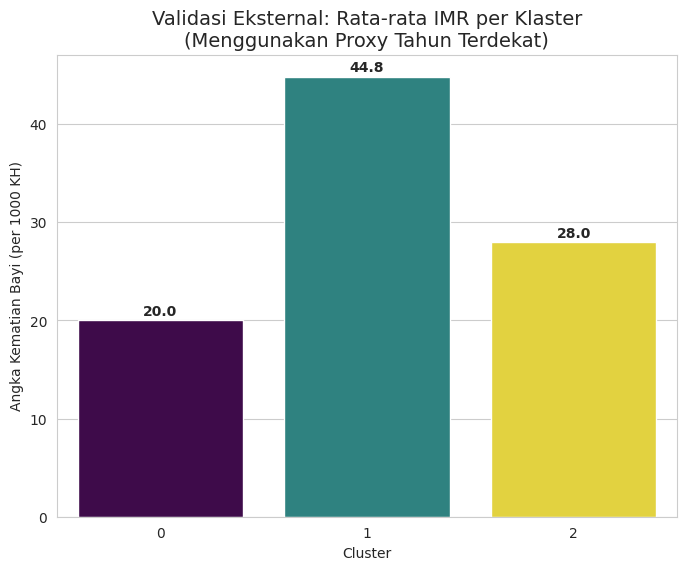

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. SIAPKAN DATA IMR ---
# Load data
df_imr = pd.read_csv("panel_imr.csv")

# Rename kolom agar standar (Pastikan nama kolom 'akb' sesuai dengan di csv kamu)
# Misal di CSV namanya 'nilai_imr' atau 'akb', ubah jadi 'IMR_Score'
df_imr = df_imr.rename(columns={
    'tahun': 'year',
    'provinsi': 'province_name',
    'imr_per_1k': 'IMR_Score'          # GANTI 'akb' dengan nama kolom angka kematian di csv aslimu
})

# --- 2. SIAPKAN DATA UTAMA (df) ---
# Kita butuh kolom bantuan di 'df' (bukan di df_imr) untuk nyambungin tahun
year_mapping = {
    2002: 2000,  # Tahun DHS 2002 -> Cari data IMR 2000
    2007: 2010,
    2012: 2012,
    2017: 2020
}

# Terapkan mapping ke Dataframe Utama yang ada Clusternya
df['imr_ref_year'] = df['year'].map(year_mapping)

# --- 3. LAKUKAN MERGE ---
# Gabungkan df (Kiri) dengan df_imr (Kanan)
df_val = pd.merge(
    df,
    df_imr,
    left_on=['imr_ref_year', 'province_name'], # Kunci dari df utama
    right_on=['year', 'province_name'],        # Kunci dari df imr
    how='inner'
)

# Cek hasil merge
print(f"Jumlah data setelah validasi: {len(df_val)}")

# --- 4. VISUALISASI ---
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_val,
    x='Cluster_PCA', # Pastikan nama kolom cluster sesuai (misal: 'Cluster_Name' atau 'Cluster_PCA')
    y='IMR_Score',
    order=[0, 1, 2], # Atau urutan label ['Maju', 'Transisi', 'Tertinggal']
    palette=['#440154', '#21908d', '#fde725'],
    errorbar=None
)

# Labeling
plt.title('Validasi Eksternal: Rata-rata IMR per Klaster\n(Menggunakan Proxy Tahun Terdekat)', fontsize=14)
plt.ylabel('Angka Kematian Bayi (per 1000 KH)')
plt.xlabel('Cluster')

# Tambah text rata-rata
means = df_val.groupby('Cluster_PCA')['IMR_Score'].mean()
# Loop untuk 3 cluster (0, 1, 2)
for i in range(3):
    if i in means:
        plt.text(i, means[i] + 0.5, f"{means[i]:.1f}", ha='center', fontweight='bold')

plt.show()

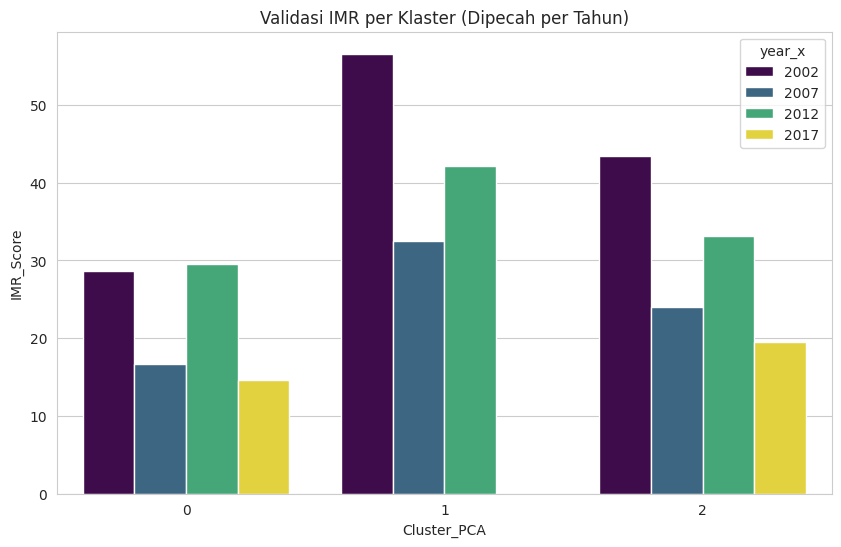

In [ ]:
# Coba plot pakai hue='year_x'
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_val,
    x='Cluster_PCA',
    y='IMR_Score',
    hue='year_x',  # <--- INI KUNCINYA
    order=[0, 1, 2],
    palette='viridis',
    errorbar=None
)
plt.title('Validasi IMR per Klaster (Dipecah per Tahun)')
plt.show()